# Intro Chatbot with Search using LangGraph

In [6]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model

In [2]:
# state where we can add messages as we update the state
graph_builder = StateGraph(MessagesState)

In [3]:
llm = init_chat_model("openai:gpt-4.1")

web_search_tool = TavilySearch(max_results=2)
tools = [web_search_tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [4]:
tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

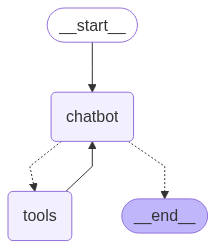

In [5]:
from IPython.display import Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
graph.invoke({"messages": ["Who won the NBA 2025?"]})

{'messages': [HumanMessage(content='Who won the NBA 2025?', additional_kwargs={}, response_metadata={}, id='d3c55f8b-36cd-409d-9df5-7343e060738a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bgc5caR8EMPS6uayKNDB1i2z', 'function': {'arguments': '{"query":"NBA 2025 champion"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 775, 'total_tokens': 795, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BosJz9ztNS9Ia10Mxt5P9hm8lI9Cb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9e1263e5-84f7-453a-bbb2-4db899556360-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'NBA 2025 champion'}, 'id': 'call_bgc5caR8

# To add Memory to our chatbot with web search

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [9]:
graph = graph_builder.compile(checkpointer=memory)

In [10]:
# pick a thread to use as the key for the conversation
config = {"configurable": {"thread_id": "1"}}

In [11]:
user_input = "Sup my name is Lucas"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Sup my name is Lucas
================================== Ai Message ==================================

Hey Lucas! How can I help you today?


In [12]:
user_input = "What is my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Lucas!
